In [2]:
from pathlib import Path
from typing import List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from torch import nn

from soundsep import open_project

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
project_dir = "/Users/frederictheunissen/Local Data/SocialZF"
project = open_project(Path(project_dir))

In [5]:
project

<Project: 5 blocks>

## Incremental training of model

Train on 10 minutes, test on next 10 minutes...

1. Define the model (2 layer convolutional network)

2. Define a data loader to train a given time range

3. Train on time range

4. Plot training data and prediction data

In [6]:
from soundsep_prediction.dataset import DatasetParameters, SoundsepAudioDataset
from soundsep_prediction.fit import partial_fit, partial_predict, partial_test
from soundsep_prediction.models import PredictionNetwork
from torch.utils.data import DataLoader

segments = pd.read_csv(project_dir + "/_appdata/save/segments.csv")

dataset = SoundsepAudioDataset(
    project_dir=Path(project_dir),
    syllable_table=segments,
    source_names=segments.SourceName.unique()
)

In [7]:
def get_loader(start_index: int, stop_index: int, batch_size: int = 64, shuffle: bool = False, workers: int = 0):
    """Get a torch DataLoader from start_index to stop_index (in project indices)"""
    ds = SoundsepAudioDataset(
        project_dir=Path(project_dir),
        syllable_table=segments,
        source_names=segments.SourceName.unique(),
        params=DatasetParameters(
            from_index=start_index,
            until_index=stop_index
        )
    )
    return DataLoader(ds, batch_size=batch_size, shuffle=shuffle, num_workers=workers)

In [8]:
dl = get_loader(0, 4100000, 64)

In [9]:
dl.dataset.syllable_table

,Unnamed: 0,SourceName,SourceChannel,StartIndex,StopIndex,Tags
0,0,7 F,4,1965,5608,"[""DC""]"
1,1,4 M,1,7921,11282,"[""Te""]"
2,2,6 F,3,16612,18858,"[""Te""]"
3,3,7 F,4,18491,26651,"[""Be""]"
4,4,6 F,3,36030,37736,"[""Te""]"
...,...,...,...,...,...,...
269,269,7 F,4,3991039,3993070,"[""Te""]"
270,270,5 M,2,4027508,4028493,"[""Te""]"
271,271,6 F,3,4031643,4033288,"[""Te""]"
272,272,7 F,4,4039828,4041945,"[""Te""]"


In [10]:
model = PredictionNetwork(channels=5, output_channels=5)

In [11]:
x1, y1 = next(iter(dl))

In [12]:
spec = model.spec(x1)

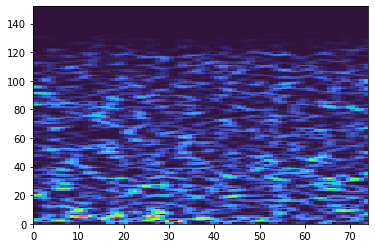

In [13]:
plt.pcolormesh(spec[50][0], cmap="turbo")

In [14]:
model.layers(x1).shape

torch.Size([64, 1536])

In [15]:
model(x1)

tensor([[-0.0363,  0.0227,  0.0340,  0.0446, -0.0327],
        [-0.0089,  0.0055,  0.0524,  0.0461, -0.0211],
        [-0.0158,  0.0150,  0.0241,  0.0383, -0.0119],
        [-0.0169,  0.0142,  0.0459,  0.0214, -0.0216],
        [-0.0117,  0.0163,  0.0520,  0.0271, -0.0130],
        [-0.0358,  0.0210,  0.0371,  0.0555, -0.0114],
        [-0.0225,  0.0027,  0.0451,  0.0297, -0.0323],
        [-0.0487,  0.0276,  0.0518,  0.0534, -0.0273],
        [-0.0355,  0.0214,  0.0508,  0.0291, -0.0089],
        [-0.0329,  0.0210,  0.0467,  0.0491, -0.0313],
        [-0.0244,  0.0269,  0.0283,  0.0290, -0.0287],
        [-0.0184,  0.0119,  0.0333,  0.0200, -0.0267],
        [-0.0262, -0.0072,  0.0418,  0.0361, -0.0136],
        [-0.0034,  0.0192,  0.0315,  0.0396, -0.0355],
        [-0.0250,  0.0115,  0.0252,  0.0498, -0.0294],
        [-0.0228,  0.0176,  0.0329,  0.0193, -0.0097],
        [-0.0245,  0.0068,  0.0390,  0.0422, -0.0119],
        [-0.0225,  0.0140,  0.0527,  0.0400, -0.0214],
        [-

In [16]:
loss = nn.BCEWithLogitsLoss()
opt = torch.optim.SGD(model.parameters(), lr=0.2)

In [17]:
partial_fit(1, model, loss, opt, get_loader(0, 1000000, 64 * 2, shuffle=True))

  0%|          | 0/178 [00:00<?, ?it/s]

0.17445248877537436

In [19]:
partial_fit(1, model, loss, opt, get_loader(1000000, 2000000, 64 * 2, shuffle=True))

0.09492896260794051

In [18]:
y_pred, y_true = partial_predict(model, get_loader(1000000, 2000000, 64 * 2))

: 

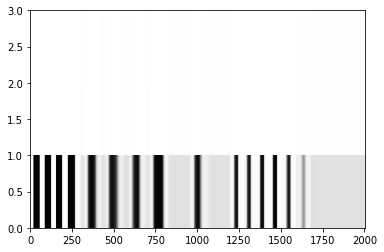

In [21]:
plt.pcolormesh(y_pred.detach().numpy().T, cmap="Greys")
plt.clim(0, 1)

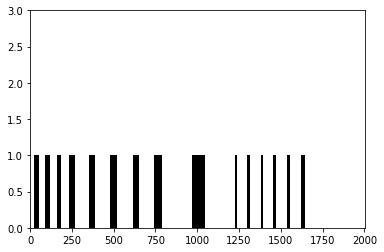

In [22]:
plt.pcolormesh(y_true.detach().numpy().T, cmap="Greys")
plt.clim(0, 1)

In [23]:
y_true.shape

torch.Size([2004, 3])

In [24]:
partial_test(model, loss, get_loader(1000, 6000, 64 * 2))

0.12097388880105796

In [ ]:
model = PredictionNetwork(channels=4, output_channels=3)
loss = nn.BCEWithLogitsLoss()

In [3]:
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

dt = 44100 * 2
for i in range(60, 80):
    t0 = i * dt
    t1 = (i + 1) * dt
    t2 = (i + 2) * dt

    train_loss = partial_fit(2, model, loss, opt, get_loader(t0, t1, 64, shuffle=True))
    print(f"Loss of {train_loss:.5f} after training")

    # test_loss = partial_test(model, loss, get_loader(t1, t2, 128, workers=4))
    # print(f"Loss of {test_loss:.5f} on next chunk")

    y_pred, y_true = partial_predict(model, get_loader(t1, t2, 64))

    fig = plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.pcolormesh(y_pred.detach().numpy().T, cmap="Greys")
    plt.clim(0, 1)
    plt.subplot(1, 2, 2)
    plt.pcolormesh(y_true.detach().numpy().T, cmap="Greys")
    plt.clim(0, 1)
    plt.show()
    plt.close(fig)

    first_window_loss = partial_test(model, loss, get_loader(0, dt, 64))
    print(f"Loss of {first_window_loss:.5f} on first window")

    print()

NameError: name 'torch' is not defined

In [1]:
plt.pcolormesh(y1.squeeze().T)

NameError: name 'plt' is not defined

In [2]:
print("hi")

hi
